<a href="https://colab.research.google.com/github/RifkiGhifari/DL-Tugas3/blob/main/TugasDLTM4DL-Tugas3/Epochs100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'az-handwritten-alphabets-in-csv-format:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F9726%2F17999%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240502%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240502T050343Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D43195eda3d2a4b869f03201fb37ca8332587fed0aa771ce11fe42e6a068f1c56a22bf976a938a715c28eb2af8692b45ac7e53d3724722b483b911a0616abf1e33a5842bf8dd74389e90aef0f7686bbb9650e3de9db82ebf865a14f0e876216296de8634b77c6fc0f935f15447f500ba56d98df50960a246e522ae2c24dc67bb0d6e86ad32f226ea5b21ad06a6643ac7887b7d2d6edb3ee851b8d121f667405e0e48ba3920bfba0abfb9be83e404b1d1f3ce9f5d47d9d67dbe78bf0e456099edc8dc580bebe16e15f9aa9062fdbfe569a21aaf60e937dfa23773ca76ec6cad5b5b34328d6281178f36032afbbbae003d18c7c0a1ed7bfb7c369b9c7d0149bb16e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 193643888 bytes downloaded
Downloaded and uncompressed: az-handwritten-alphabets-in-csv-format
Data source import complete.


In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv
/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data/A_Z Handwritten Data.csv


# Importing Necessary Libraries

In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Read The Dataset


In [9]:
data = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv").astype('float32')


In [10]:
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data.tail()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
372445,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372446,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372447,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372448,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372449,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Splitting Dataset into Labels and Images

In [12]:
X = data.drop('0',axis = 1) # axis=1 for dropping column
y = data['0']

In [13]:
X.head()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It is a 28x28 image flattened to 784 pixels

In [14]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0, dtype: float32

# Reshaping the data to display it as image and splitting the Dataset as Test and Train data

In [27]:
from sklearn.model_selection import train_test_split

# Splitting into 70% training and 30% remaining
X_train, X_rem, Y_train, Y_rem = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split remaining into 50% validation and 50% test
X_val, X_test, Y_val, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5, random_state=42)

# Reshaping
X_train = X_train.values.reshape(-1, 28, 28)
X_val = X_val.values.reshape(-1, 28, 28)
X_test = X_test.values.reshape(-1, 28, 28)

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)


Train data shape: (260715, 28, 28)
Validation data shape: (55867, 28, 28)
Test data shape: (55868, 28, 28)


# Creating dictionary of column number to corresponding letter

In [28]:
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'}

# Plotting Count of Each Alphabet in Dataset

<ipython-input-29-545ab8b21fb9>:1: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  y_int = np.int0(y)


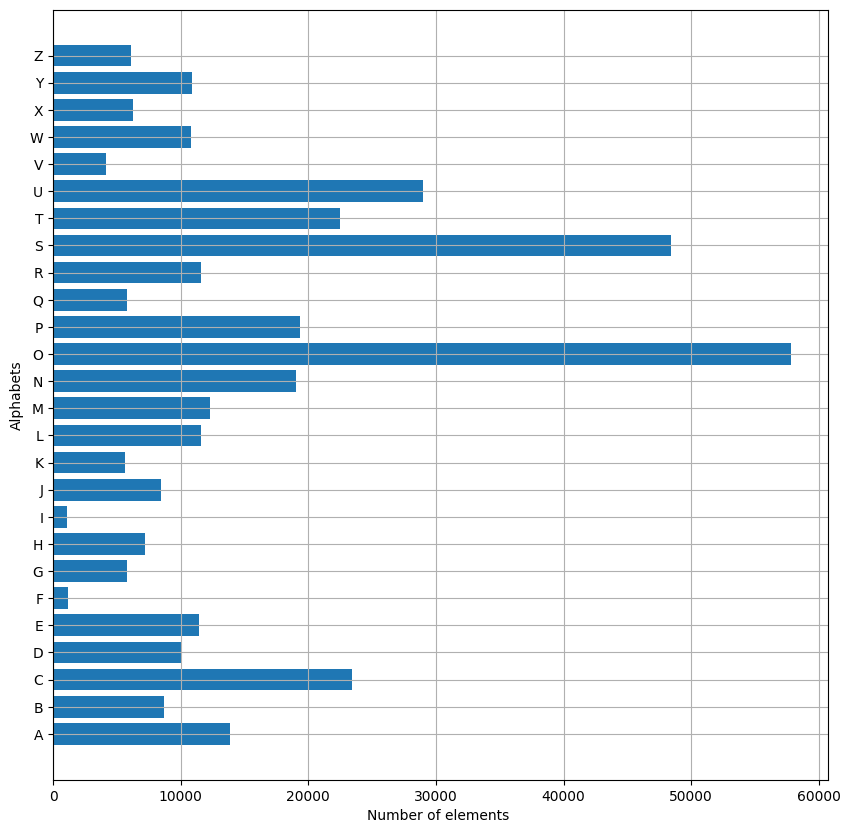

In [29]:
y_int = np.int0(y)
count = np.zeros(26, dtype='int') #a vector of size 26 with all 0 values
for i in y_int:
    count[i] +=1 #total count of each alphabet

alphabets = []
for i in word_dict.values():
    alphabets.append(i) #all alphabets

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.barh(alphabets, count)

plt.xlabel("Number of elements ")
plt.ylabel("Alphabets")
plt.grid()
plt.show()

# Displaying few letters

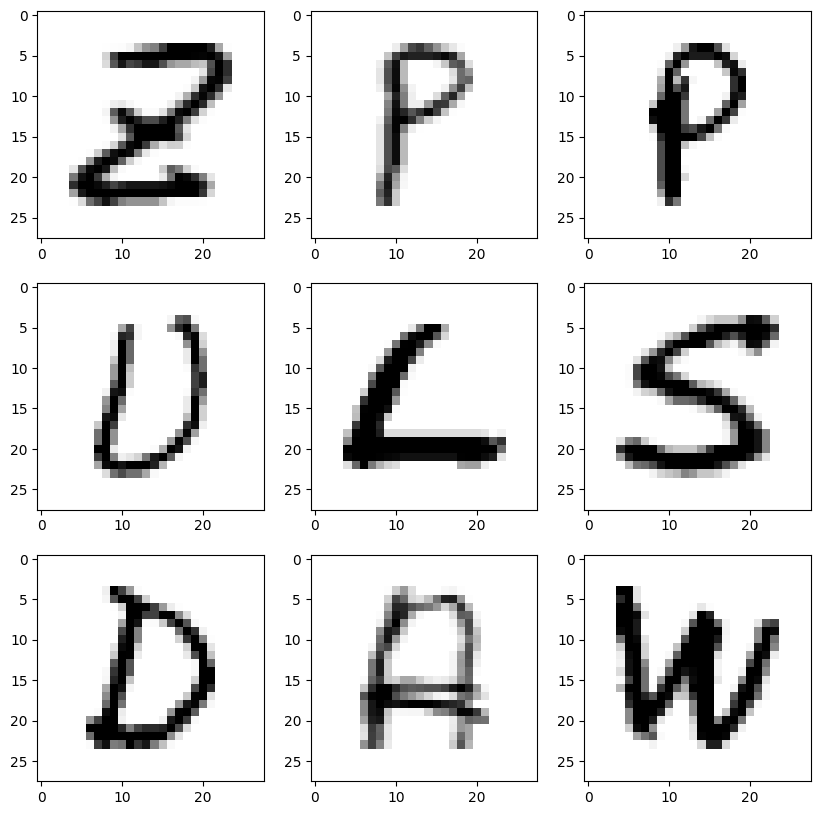

In [30]:
shuff = shuffle(X_train[:100])

fig, ax = plt.subplots(3,3, figsize = (10,10))
axes = ax.flatten()

for i in range(9):
    _, shu = cv2.threshold(shuff[i], 30, 200, cv2.THRESH_BINARY)
    axes[i].imshow(np.reshape(shuff[i], (28,28)), cmap="Greys")
plt.show()

# Reshaping data to feed to CNN

In [31]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1) #RGB =>Channel of 1
print("New shape of train data: ", X_train.shape)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2],1) #RGB =>Channel of 1
print("New shape of train data: ", X_test.shape)

New shape of train data:  (260715, 28, 28, 1)
New shape of train data:  (55868, 28, 28, 1)


# Converting Single float value to Categorical Values

In [32]:
train_yOHE = to_categorical(Y_train, num_classes = 26, dtype='int')
print("New shape of train labels: ", train_yOHE.shape)

test_yOHE = to_categorical(Y_test, num_classes = 26, dtype='int')
print("New shape of test labels: ", test_yOHE.shape)

New shape of train labels:  (260715, 26)
New shape of test labels:  (55868, 26)


# Building CNN Model

In [33]:
model = Sequential()
#CNN
# input -> conv -> maxpool -> conv -> maxpool ......->flattened vector->
#.                        hidden layer -> hidden layer -> softmax layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(26,activation ="softmax"))

# Compiling and Training the CNN

In [34]:
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, train_yOHE, epochs=100,  validation_data = (X_test,test_yOHE))

Epoch 1/100
8148/8148 [==============================] - 307s 38ms/step - loss: 0.1772 - accuracy: 0.9524 - val_loss: 0.0954 - val_accuracy: 0.9729
Epoch 2/100
8148/8148 [==============================] - 316s 39ms/step - loss: 0.0760 - accuracy: 0.9790 - val_loss: 0.0753 - val_accuracy: 0.9794
Epoch 3/100
8148/8148 [==============================] - 306s 38ms/step - loss: 0.0628 - accuracy: 0.9828 - val_loss: 0.0642 - val_accuracy: 0.9824
Epoch 4/100
8148/8148 [==============================] - 299s 37ms/step - loss: 0.0556 - accuracy: 0.9849 - val_loss: 0.0613 - val_accuracy: 0.9842
Epoch 5/100
8148/8148 [==============================] - 299s 37ms/step - loss: 0.0514 - accuracy: 0.9860 - val_loss: 0.0613 - val_accuracy: 0.9858
Epoch 6/100
8148/8148 [==============================] - 304s 37ms/step - loss: 0.0494 - accuracy: 0.9870 - val_loss: 0.0675 - val_accuracy: 0.9833
Epoch 7/100
8148/8148 [==============================] - 305s 37ms/step - loss: 0.0480 - accuracy: 0.9875 - val_

KeyboardInterrupt: 

# Printing Model Summary

In [35]:
model.summary()
model.save(r'model_hand.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 128)        

In [36]:
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation accuracy is : [0.9731373190879822]
The training accuracy is : [0.9558262825012207]
The validation loss is : [0.09385567158460617]
The training loss is : [0.16075800359249115]


# Making Predictions

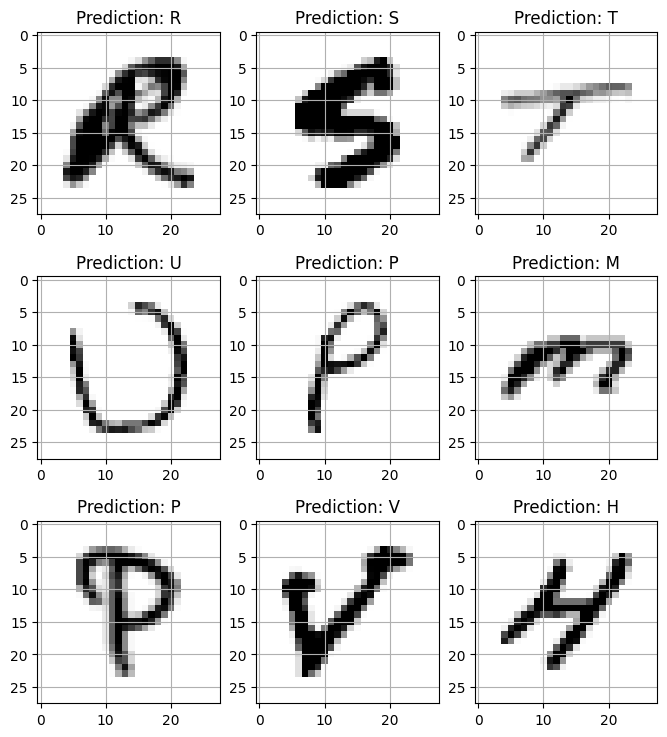

In [37]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(X_test[i], (28,28))
    ax.imshow(img, cmap="Greys")

    pred = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()

1/1 [==============================] - 0s 30ms/step


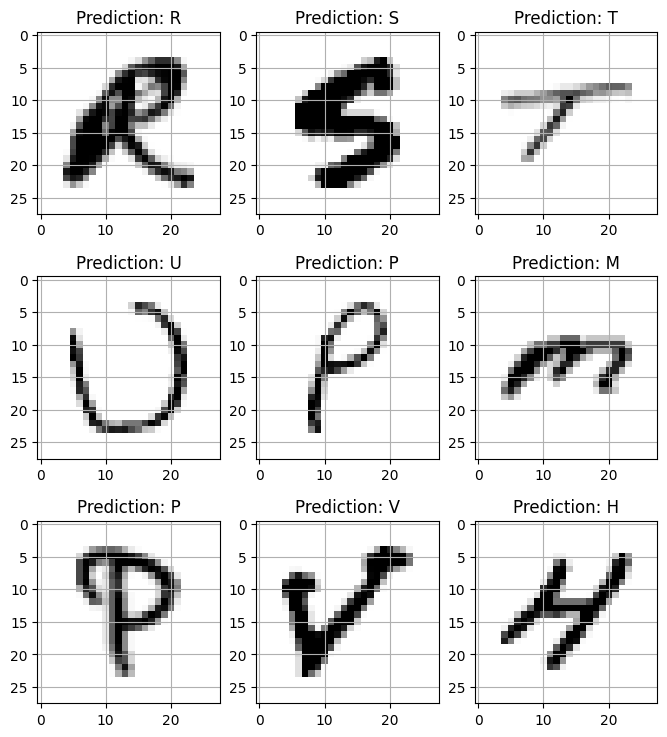

In [38]:
fig, axes = plt.subplots(3,3, figsize=(8,9))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(X_test[i], (28,28)) # reshaping it for displaying
    ax.imshow(img, cmap="Greys")
    img_final =np.reshape(img, (1,28,28,1)) # reshapng it for passing into model for prediction
    pred = word_dict[np.argmax(model.predict(img_final))]
    ax.set_title("Prediction: "+pred)
    ax.grid()